# TKC Magnetics

*Where are the diamonds: Using Earth's Potential Fields (Magnetics)*

In this tutorial we will run a magnetic inverse problem from an input file.
The synthetic example used is based on the TKC kimberlite deposit, Northwest Territories. We are attempting to use the magnetic field to image the various rock units making up the diamond deposit.
We will skip the model creation for now, at it is quite involved and out of scope for this notebook. 

In [1]:
## First we need to load all the libraries and set up the path
## for the input files. Same files as used by the online tutorial
%matplotlib notebook
import scipy as sp
import numpy as np
import time as tm
import os
import shutil
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from SimPEG import Mesh, Utils, Maps, Regularization, DataMisfit, Optimization, InvProblem, Directives, Inversion, PF
from SimPEG.Utils.io_utils import download




In [2]:
psep = os.path.sep
url = 'https://storage.googleapis.com/simpeg/tkc_synthetic/potential_fields/'
cloudfiles = ['MagData.obs', 'Mesh.msh',
              'Initm.sus', 'SimPEG_PF_Input.inp']

downloads = download([url+f for f in cloudfiles], folder='./MagTKC/', overwrite=True)
downloads = dict(zip(cloudfiles, downloads))
input_file = downloads['SimPEG_PF_Input.inp']

overwriting C:\Users\DominiqueFournier\Desktop\MagTKC\MagData.obs
overwriting C:\Users\DominiqueFournier\Desktop\MagTKC\Mesh.msh
overwriting C:\Users\DominiqueFournier\Desktop\MagTKC\Initm.sus
overwriting C:\Users\DominiqueFournier\Desktop\MagTKC\SimPEG_PF_Input.inp
   saved to: C:\Users\DominiqueFournier\Desktop\MagTKC\MagData.obs
   saved to: C:\Users\DominiqueFournier\Desktop\MagTKC\Mesh.msh
   saved to: C:\Users\DominiqueFournier\Desktop\MagTKC\Initm.sus
   saved to: C:\Users\DominiqueFournier\Desktop\MagTKC\SimPEG_PF_Input.inp
Download completed!


In [3]:
# Read in the input file which included all parameters at once (mesh, topo, model, survey, inv param, etc.)
driver = PF.MagneticsDriver.MagneticsDriver_Inv(input_file)

In [4]:
# We already have created a mesh, model and survey for this example.
# All the elements are stored in the driver, and can be accessed like this:
mesh = driver.mesh
survey = driver.survey

**Setup**

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [5]:
# We did not include a topography file in this example as the information
# about inactive cells is already captured in our starting model.
# Line 6 of the input file specifies a VALUE to be used as inactive flag.

# Get the active cells
actv = driver.activeCells
nC = len(actv) # Number of active cells
ndv = -100

# Create active map to return to full space after the inversion 
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)

# Create a reduced identity map for the inverse problem
idenMap = Maps.IdentityMap(nP=nC)


## Forward system:

Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [6]:
# Now that we have a model and a survey we can build the linear system ...
# Create the forward model operator (the argument forwardOnly=False store the forward matrix to memory)
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv, forwardOnly=False)

# Pair the survey and problem
survey.pair(prob)

Begin forward: M=H0, Rx type= tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %


<IPython.core.display.Javascript object>


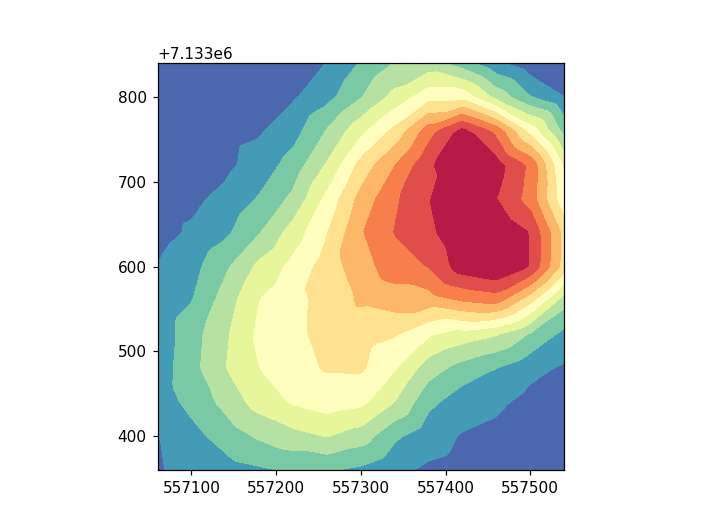

In [7]:
# Fist time that we ask for predicted data,
# the dense matrix T is calculated.
# This is generally the bottleneck of the integral formulation in terms of cost
d = prob.fields(driver.m0)

# Add noise to the data and assign uncertainties
data = d + np.random.randn(len(d)) # We add some random Gaussian noise (1nT)
wd = np.ones(len(data))*1. # Assign flat uncertainties

survey.dobs = data
survey.std = wd

# [OPTIONAL] You can write the observations to UBC format here
#PF.Magnetics.writeUBCobs('MAG_Synthetic_data.obs',survey,data)
fig = Utils.PlotUtils.plot2Ddata(survey.srcField.rxList[0].locs, data, contourOpts={"cmap":"Spectral_r"})

## Inverse problem

We have generated synthetic data, we now what to see if we can solve the inverse. Using the usual formulation, we seek a model that can reproduce the data, let’s say a least-squares measure of the form:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2
\end{equation}

The inverse problem is hard because we don’t have great data coverage, and the Earth is big, and there is usually noise in the data. So we need to add something to regularize it.
The simplest way to do it is to penalize solutions that won’t make sense geologically, for example to assume that the model is small.
The usual smooth inversion function use an l2-norm measure:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 \\
\phi_m = \beta \Big [ {\| \mathbf{W}_s \;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}

The full objective function to be minimized can be written as:
\begin{equation}
\phi(m) =  \phi_d + \beta \phi_m\;,
\end{equation}
which will yield our usual *small* and *smooth* models. 

We propose a fancier regularization function that can allow to recover *sparse* and *blocky* solutions.
Starting with the well known Ekblom norm:
\begin{equation}
\phi_m =  \sum_{i=1}^{nc} {(x_i^2 + \epsilon^2)}^{p/2} \;,
\end{equation}
where $x_i$ denotes some function of the model parameter, and $\epsilon$ is a small value to avoid singularity as $m\rightarrow0$.
For p=2, we get the usual least-squares measure and we recover the regularization presented above. For $p \leq 1$, the function becomes non-linear which requires some tweaking.

We can linearize the function by updating the penality function iteratively, commonly known as an Iterative Re-weighted Least-Squares (IRLS) method:
\begin{equation} 
\phi_m^{(k)} =  \frac{1}{2}\sum_{i=1}^{nc} r_i \; x_i^2
\end{equation}
where we added the superscript $\square^{(k)}$ to denote the IRLS iterations. The weights $r(x)$ are computed from model values obtained at a previous iteration such that:
\begin{equation}
	{r}_i  ={\Big( {({x_i}^{(k-1)})}^{2} + \epsilon^2 \Big)}^{p/2 - 1} \;,
\end{equation}
where ${r}(x) \in \mathbb{R}^{nc}$.

In matrix form, our objective function simply becomes:
\begin{equation}
\phi(m) =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 + \beta \Big [ {\| \mathbf{W}_s \;\mathbf{R}_s\;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i\; \mathbf{R}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}
where the IRLS weights $\mathbf{R}_s$ and $\mathbf{R}_i$ are diagonal matrices defined as:
\begin{equation}
\begin{split}
	{R}_{s_{jj}}  &=  \sqrt{\eta_p}{\Big[ {({m_j}^{(k-1)})}^{2} + \epsilon_p^2 \Big]}^{(p/2 - 1)/2} \\
	{R}_{i_{jj}}  &=  \sqrt{\eta_q}{\Big[ {\left ({{(G_i\;m^{(k-1)})}_j }\right)}^{2} + \epsilon_q^2 \Big]}^{(q/2 - 1)/2} \\
\eta_p &=  {\epsilon_p}^{(1-p/2)} \\
\eta_q &=   {\epsilon_q}^{(1-q/2)}  \;, 
\end{split}
\end{equation}

we added two scaling parameters $\eta_p$ and $\eta_q$ for reasons that we won't dicuss here, but turn out to be important to get stable solves.

In order to initialize the IRLS and get an estimate for the stabilizing parameters $\epsilon_p$ and $\epsilon_q$, we first invert with the smooth $l_2$-norm. 
The whole IRLS process is implemented with a directive added to the inversion workflow (see below).


In [8]:
# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
wr = np.sum(prob.G**2.,axis=0)**0.5
wr = ( wr/np.max(wr) )
    
# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='total')
reg.norms = np.c_[0.5,0,0,0]
reg.cell_weights = wr

dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100 ,lower=0.,upper=1., maxIterLS = 20, maxIterCG= 10, tolCG = 1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of model
# parameters (run last cell to see the histogram before and after IRLS)
IRLS = Directives.Update_IRLS(f_min_change = 1e-4, minGNiter=1, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb, directiveList=[betaest,IRLS,update_Jacobi])

m0 = np.ones(idenMap.nP)*1e-4


SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [9]:
# Run inversion...
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.43e+07  2.87e+05  0.00e+00  2.87e+05    1.45e+02      0              
   1  7.13e+06  2.37e+04  1.74e-03  3.61e+04    1.25e+02      0              
   2  3.57e+06  6.61e+03  2.93e-03  1.70e+04    8.95e+01      0   Skip BFGS  
   3  1.78e+06  2.59e+03  3.60e-03  9.01e+03    1.20e+02      0   Skip BFGS  
   4  8.92e+05  9.75e+02  4.18e-03  4.70e+03    1.26e+02      0   Skip BFGS  
   5  4.46e+05  3.73e+02  4.63e-03  2.44e+03    1.17e+02      0   Skip BFGS  
   6  2.23e+05  1.41e+

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:830: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


   7  1.11e+05  5.60e+01  7.43e-03  8.85e+02    8.20e+01      0   Skip BFGS  
delta phim: 4.506e+03
   8  2.60e+05  3.17e+01  9.05e-03  2.39e+03    1.04e+02      0   Skip BFGS  
delta phim: 4.303e-01
   9  1.82e+05  1.29e+02  1.03e-02  2.01e+03    8.41e+01      0              
delta phim: 4.114e-01
  10  1.27e+05  1.32e+02  1.11e-02  1.54e+03    7.61e+01      4   Skip BFGS  
delta phim: 3.563e-01
  11  2.12e+05  6.30e+01  1.32e-02  2.87e+03    4.14e+01      0              
delta phim: 4.864e-01
  12  1.32e+05  1.69e+02  1.46e-02  2.11e+03    1.28e+02      0              
delta phim: 3.726e-01
  13  9.20e+04  1.32e+02  1.66e-02  1.66e+03    1.04e+02      0              
delta phim: 2.574e-01
  14  6.53e+04  1.26e+02  1.80e-02  1.30e+03    6.09e+01      0   Skip BFGS  
delta phim: 1.432e-01
  15  6.53e+04  9.12e+01  1.89e-02  1.32e+03    9.66e+01      0              
delta phim: 9.413e-02
  16  4.92e+04  1.12e+02  1.91e-02  1.05e+03    1.33e+02      0              
delta phim: 5.729e-02


<IPython.core.display.Javascript object>


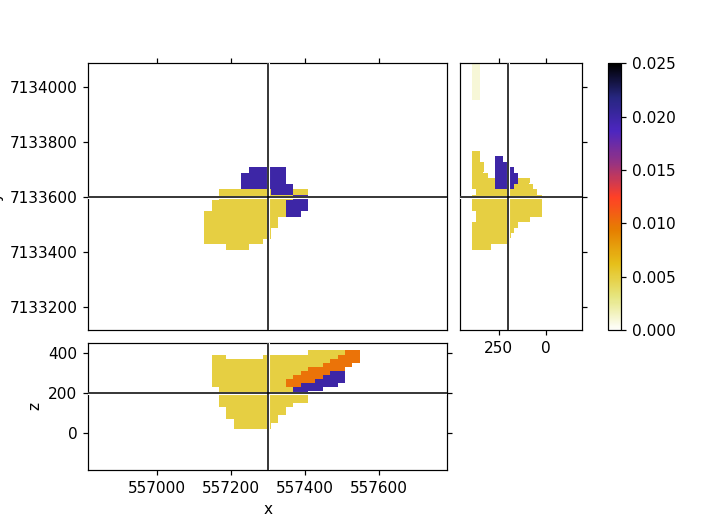

<IPython.core.display.Javascript object>


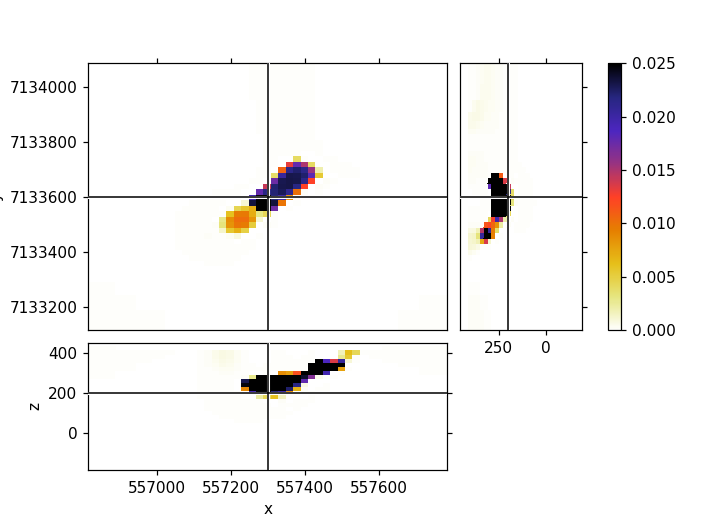

<IPython.core.display.Javascript object>


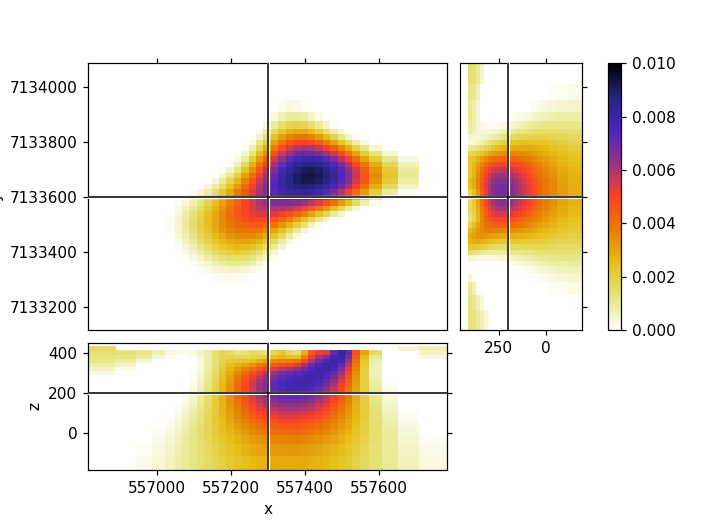

In [10]:
# Get the final model back to full space and plot!!
m_lp = actvMap*mrec
m_lp[m_lp==ndv] = np.nan

# Get the smooth model aslo
m_l2 = actvMap*invProb.l2model
m_l2[m_l2==ndv] = np.nan

m_true = actvMap*driver.m0
m_true[m_true==ndv] = np.nan
#[OPTIONAL] Save both models to file
#Mesh.TensorMesh.writeModelUBC(mesh,'SimPEG_MAG_l2l2.sus',m_l2)
#Mesh.TensorMesh.writeModelUBC(mesh,'SimPEG_MAG_lplq.sus',m_lp)

# Plot the recoverd models 
vmin, vmax = 0., 0.015

mesh.plot_3d_slicer(m_true, pcolorOpts={"vmax":0.025, "cmap":"CMRmap_r"})

mesh.plot_3d_slicer(m_lp, pcolorOpts={"vmax":0.025, "cmap":"CMRmap_r"})

mesh.plot_3d_slicer(m_l2, pcolorOpts={"vmax":0.01, "cmap":"CMRmap_r"})


<IPython.core.display.Javascript object>


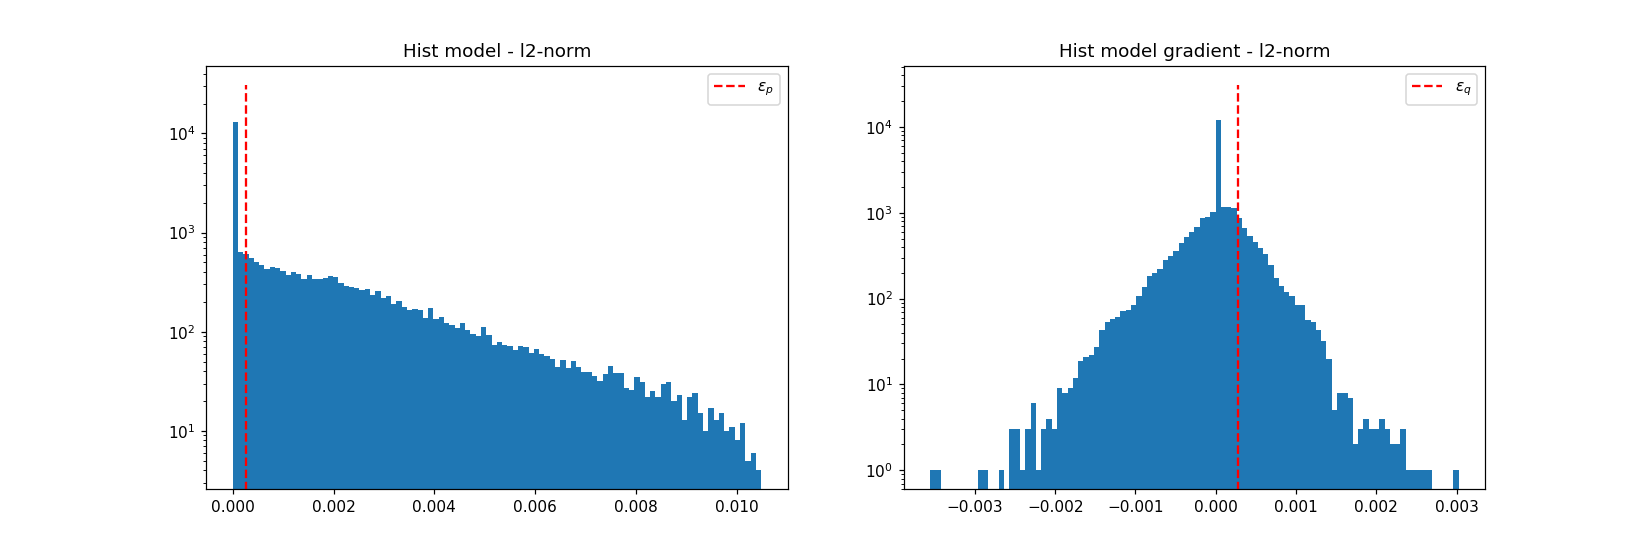

<IPython.core.display.Javascript object>


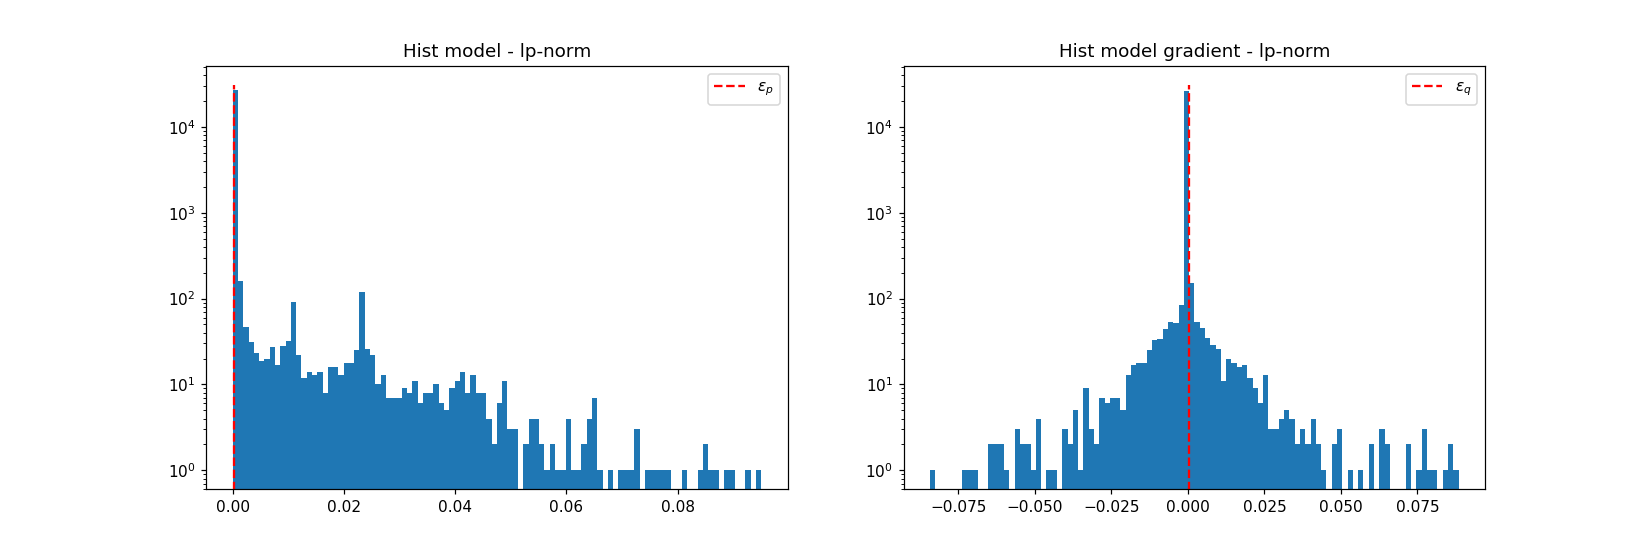

In [11]:
# Lets compare the distribution of model parameters and model gradients
plt.figure(figsize=[15,5])
ax = plt.subplot(121)
plt.hist(invProb.l2model,100)
plt.plot((reg.eps_p,reg.eps_p),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model - l2-norm')
plt.legend(['$\epsilon_p$'])

ax = plt.subplot(122)
plt.hist(reg.regmesh.cellDiffxStencil*invProb.l2model,100)
plt.plot((reg.eps_q,reg.eps_q),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model gradient - l2-norm')
plt.legend(['$\epsilon_q$'])

# Lets look at the distribution of model parameters and model gradients
plt.figure(figsize=[15,5])
ax = plt.subplot(121)
plt.hist(mrec,100)
plt.plot((reg.eps_p,reg.eps_p),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model - lp-norm')
plt.legend(['$\epsilon_p$'])

ax = plt.subplot(122)
plt.hist(reg.regmesh.cellDiffxStencil*mrec,100)
plt.plot((reg.eps_q,reg.eps_q),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model gradient - lp-norm')
plt.legend(['$\epsilon_q$'])